In [115]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import lars_path, LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import requests, io, re

from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [116]:
# Import data
data_apr = pd.read_csv("/Users/galamboslajos/Desktop/Amsterdam_HW2/listings_amsterdam_FINAL.csv")
data_apr.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,...,license,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ln_price,property_House,property_Private room,property_Shared Room
0,100%,100%,t,2,2,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Noord-Oost,...,0363 D4AD DCF3 E72A 56A2,2,0,2,0,2.30,4.110874,False,True,False
1,100%,100%,f,1,4,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Westerpark,...,0363 7A50 18E7 51D1 B7F9,1,1,0,0,0.64,5.789960,True,False,False
2,100%,100%,t,3,3,"['email', 'phone', 'work_email']",t,t,"Amsterdam, North Holland, Netherlands",Westerpark,...,036396BE30827DDB9575,3,1,2,0,2.73,4.691348,False,True,False
3,100%,97%,t,2,2,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Centrum-West,...,0363 8C61 E9B9 5582 913E,2,0,2,0,6.62,5.010635,False,True,False
4,100%,100%,t,2,2,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",Slotervaart,...,0363 BCBA 6311 3268 DC8C,2,0,2,0,2.20,4.317488,False,True,False


In [117]:
columns_to_drop = ['host_verifications', 'latitude', 'longitude', 'host_listings_count',
                   'host_total_listings_count', 'maximum_nights_avg_ntm', 'minimum_minimum_nights', 'calendar_last_scraped',
                   'first_review']

data_apr.drop(columns_to_drop, axis=1, inplace=True)

In [118]:
# Keep obs with 2 < accommodates < 6, and property_House = 1 only
data_apr = data_apr[(data_apr['accommodates'] >= 2) & (data_apr['accommodates'] <= 6) & (data_apr['property_House'] == 1)]


In [119]:
# Formatting columns    
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
]:
    data_apr[binary] = data_apr[binary].map({"t": True, "f": False})

data_apr["f_property_type"] = data_apr["property_type"].astype("category")
data_apr["f_neighbourhood_cleansed"] = data_apr["neighbourhood_cleansed"].astype("category")
data_apr['n_bathroom'] = data_apr['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
data_apr['host_acceptance_rate'] = data_apr['host_acceptance_rate'].str.replace('%', '').astype(float)
data_apr['host_response_rate'] = data_apr['host_response_rate'].str.replace('%', '').astype(float)

In [120]:
import re
from collections import Counter

# Loop through each row in the 'amenities' column
all_amenities = []

for row in data_apr['amenities']:
    # Remove leading and trailing brackets and then split into a list
    amenities_list = [re.sub(r'[^\w\s]', '', amenity.strip(' "')) for amenity in row.strip('][').split(', ')]
    all_amenities.extend(amenities_list)

# Count occurrences of each amenity
amenities_counter = Counter(all_amenities)

# Select the top 150 most frequent amenities
top_150_amenities = [amenity for amenity, _ in amenities_counter.most_common(150)]
for amenity in top_150_amenities:
    data_apr[f'd_{amenity}'] = data_apr['amenities'].apply(lambda x: 1 if amenity in x else 0)

# List columns to drop
columns_to_drop = [col for col in data_apr.columns if col.startswith('d_') and col not in [f'd_{amenity}' for amenity in top_150_amenities]]

# Drop columns
data_apr.drop(columns=columns_to_drop, inplace=True)

# Rename columns by replacing spaces with underscores
columns_to_rename = [col for col in data_apr.columns if col.startswith('d_')]
for col in columns_to_rename:
    new_col_name = col.replace(' ', '_')
    data_apr.rename(columns={col: new_col_name}, inplace=True)


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [121]:
data_apr

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,...,d_Childrenu2019s_books_and_toys_for_ages_02_years_old_and_25_years_old,d_Free_dryer,d_Game_console_PS4,d_Coffee_maker_french_press,d_Crib__available_upon_request,d_Window_guards,d_Central_air_conditioning,d_Portable_air_conditioning,d_Crib__always_at_the_listing,d_Breakfast
1,100.0,100.0,False,True,True,"Amsterdam, North Holland, Netherlands",Westerpark,House,2,2 baths,...,0,0,0,0,0,0,1,0,0,0
12,NaN,NaN,False,True,True,"Amsterdam, Noord-Holland, Netherlands",Centrum-Oost,House,4,1.5 baths,...,0,0,0,0,0,0,0,0,0,0
13,100.0,33.0,False,True,True,"Amsterdam, Noord-Holland, Netherlands",Buitenveldert - Zuidas,House,4,1.5 baths,...,0,1,0,0,0,0,0,0,0,0
14,100.0,93.0,True,True,True,"Amsterdam, North Holland, Netherlands",Centrum-West,House,3,1 bath,...,0,0,0,0,0,0,0,0,0,0
15,100.0,91.0,False,True,True,"Amsterdam, North Holland, Netherlands",Centrum-Oost,House,4,1.5 baths,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8100,NaN,NaN,False,True,True,"Amsterdam, Noord-Holland, Netherlands",De Pijp - Rivierenbuurt,House,2,1.5 baths,...,0,1,0,0,0,0,0,0,0,0
8101,100.0,100.0,False,True,True,"Amsterdam, Noord-Holland, Netherlands",Oud-Oost,House,3,1 bath,...,0,0,0,0,0,0,0,0,0,0
8102,NaN,NaN,False,True,True,NaN,Oud-Noord,House,2,1 bath,...,0,0,0,0,0,0,0,0,0,0
8104,100.0,83.0,False,True,True,"Amsterdam, Noord-Holland, Netherlands",Bos en Lommer,House,2,1.5 baths,...,0,1,0,0,0,0,0,0,0,0


In [122]:
numericals = [
    "accommodates",
    "availability_365",
    "review_scores_value",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "reviews_per_month",
    "minimum_nights",
    "maximum_nights",
    "beds",
    "bedrooms",
    "host_acceptance_rate",
    "host_response_rate",
]

for col in numericals:
    data_apr["n_" + col] = pd.to_numeric(data_apr[col], errors="coerce")

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [123]:
data_apr["n_review_scores_value"].fillna(data_apr["n_review_scores_value"].mean(), inplace=True)
data_apr["n_review_scores_location"].fillna(data_apr["n_review_scores_location"].mean(), inplace=True)
data_apr["n_review_scores_communication"].fillna(data_apr["n_review_scores_communication"].mean(), inplace=True)
data_apr["n_review_scores_checkin"].fillna(data_apr["n_review_scores_checkin"].mean(), inplace=True)
data_apr["n_reviews_per_month"].fillna(data_apr["n_reviews_per_month"].mean(), inplace=True)
data_apr["n_bedrooms"].fillna(data_apr["n_bedrooms"].mean(), inplace=True)
data_apr["n_host_acceptance_rate"].fillna(data_apr["n_host_acceptance_rate"].mean(), inplace=True)
data_apr["n_host_response_rate"].fillna(data_apr["n_host_response_rate"].mean(), inplace=True)

data_apr = data_apr.assign(
    flag_review_scores_value=np.multiply(data_apr.n_review_scores_value.isna(), 1),
    n_review_scores_value=data_apr.n_review_scores_value.fillna(
        np.mean(data_apr.n_review_scores_value.dropna())
    ),
    flag_review_scores_location=np.multiply(data_apr.n_review_scores_location.isna(), 1),
    n_review_scores_location=data_apr.n_review_scores_location.fillna(
        np.mean(data_apr.n_review_scores_location.dropna())
    ),

    flag_review_scores_communication=np.multiply(data_apr.n_review_scores_communication.isna(), 1),
    n_review_scores_communication=data_apr.n_review_scores_communication.fillna(
        np.mean(data_apr.n_review_scores_communication.dropna())
    ),

    flag_review_scores_checkin=np.multiply(data_apr.n_review_scores_checkin.isna(), 1),
    n_review_scores_checkin=data_apr.n_review_scores_checkin.fillna(
        np.mean(data_apr.n_review_scores_checkin.dropna())
    ),

    flag_reviews_per_month=np.multiply(data_apr.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data_apr.n_reviews_per_month.fillna(
        np.mean(data_apr.n_reviews_per_month.dropna())
    ),

    flag_review_scores_cleanliness=np.multiply(data_apr.n_review_scores_cleanliness.isna(), 1),
    n_review_scores_cleanliness=data_apr.n_review_scores_cleanliness.fillna(
        np.mean(data_apr.n_review_scores_cleanliness.dropna())
    ),
    flag_bedrooms=np.multiply(data_apr.n_bedrooms.isna(), 1),
    n_bedrooms=data_apr.n_bedrooms.fillna(
        np.mean(data_apr.n_bedrooms.dropna())
    ),
    flag_host_acceptance_rate=np.multiply(data_apr.host_acceptance_rate.isna(), 1),
    n_host_acceptance_rate=data_apr.host_acceptance_rate.fillna(
        np.mean(data_apr.host_acceptance_rate.dropna())
    ),
    flag_host_response_rate=np.multiply(data_apr.host_response_rate.isna(), 1),
    n_host_response_rate=data_apr.host_response_rate.fillna(
        np.mean(data_apr.host_response_rate.dropna())
    ),
)

In [124]:
columns_to_check = ['n_bathroom', 'n_beds', 'host_has_profile_pic']
data_apr.dropna(subset=columns_to_check, inplace=True)

In [125]:
data_apr = data_apr.drop(columns=['neighbourhood'])

In [126]:
mean_acceptance_rate = data_apr['host_acceptance_rate'].mean()
data_apr['host_acceptance_rate'].fillna(mean_acceptance_rate, inplace=True)
mean_response_rate = data_apr['host_response_rate'].mean()
data_apr['host_response_rate'].fillna(mean_response_rate, inplace=True)
mean_bedroom = data_apr['bedrooms'].mean()
data_apr['bedrooms'].fillna(mean_bedroom, inplace=True)
data_apr.dropna(subset=['host_is_superhost'], inplace=True)


In [127]:
missing_values = data_apr.isnull().sum()
missing_values


host_response_rate                0
host_acceptance_rate              0
host_is_superhost                 0
host_has_profile_pic              0
host_identity_verified            0
                                 ..
flag_reviews_per_month            0
flag_review_scores_cleanliness    0
flag_bedrooms                     0
flag_host_acceptance_rate         0
flag_host_response_rate           0
Length: 216, dtype: int64

In [128]:
data_apr.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,bedrooms,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
1,100.000000,100.000000,False,True,True,Westerpark,House,2,2 baths,1.0,...,100.000000,0,0,0,0,0,0,0,0,0
12,93.566146,72.258761,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,93.591827,0,0,0,0,0,0,0,1,1
13,100.000000,33.000000,False,True,True,Buitenveldert - Zuidas,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
14,100.000000,93.000000,True,True,True,Centrum-West,House,3,1 bath,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
15,100.000000,91.000000,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0


In [129]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_bedrooms",
    "n_bathroom",
    "n_beds",
    #"f_neighbourhood_cleansed",
    "n_availability_365",
    "n_minimum_nights",
    "n_maximum_nights",
    "host_is_superhost",
    "n_host_acceptance_rate",
    "host_has_profile_pic",
    "n_host_response_rate",
]

# reviews
reviews = [
    "n_review_scores_value",
    "flag_review_scores_value",
    "n_review_scores_location",
    "flag_review_scores_location",
    "n_review_scores_communication",
    "flag_review_scores_communication",
    "n_review_scores_checkin",
    "flag_review_scores_checkin",
    "n_review_scores_cleanliness",
    "flag_review_scores_cleanliness",
    "n_reviews_per_month",
    "flag_reviews_per_month"
]

amenities = [col for col in data_apr if col.startswith("d_")]

# interactions
X1 = [
    "n_minimum_nights:n_accommodates",
    "n_availability_365:minimum_nights",
    "n_review_scores_value:n_reviews_per_month",
    "n_host_acceptance_rate:n_host_response_rate",
    "host_identity_verified:host_is_superhost",
]
# interactions with neighbourhood
X2 = [
    "n_availability_365:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [130]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_3 = basic_vars + reviews + amenities + X1 + X2

In [131]:
amenities

['d_Kitchen',
 'd_Smoke_alarm',
 'd_Wifi',
 'd_Essentials',
 'd_Dishes_and_silverware',
 'd_Hot_water',
 'd_Refrigerator',
 'd_Cooking_basics',
 'd_Iron',
 'd_Hair_dryer',
 'd_Hangers',
 'd_Bed_linens',
 'd_Dishwasher',
 'd_Washer',
 'd_Dedicated_workspace',
 'd_Carbon_monoxide_alarm',
 'd_Heating',
 'd_Shampoo',
 'd_Cleaning_products',
 'd_Oven',
 'd_TV',
 'd_Microwave',
 'd_Private_entrance',
 'd_Dining_table',
 'd_Wine_glasses',
 'd_Coffee_maker',
 'd_Freezer',
 'd_Fire_extinguisher',
 'd_Hot_water_kettle',
 'd_First_aid_kit',
 'd_Private_patio_or_balcony',
 'd_Drying_rack_for_clothing',
 'd_Stove',
 'd_Extra_pillows_and_blankets',
 'd_Shower_gel',
 'd_Coffee',
 'd_Outdoor_furniture',
 'd_Outdoor_dining_area',
 'd_Central_heating',
 'd_Host_greets_you',
 'd_Body_soap',
 'd_Bathtub',
 'd_Roomdarkening_shades',
 'd_Toaster',
 'd_Free_dryer_u2013_In_unit',
 'd_Blender',
 'd_Laundromat_nearby',
 'd_Books_and_reading_material',
 'd_Dryer',
 'd_Free_washer_u2013_In_unit',
 'd_Luggage_drop

In [132]:
data_apr.to_csv('/Users/galamboslajos/Desktop/Amsterdam_HW2/listingAMS_Final.csv', index = False)

In [133]:
#Split the data
data_train, data_holdout = train_test_split(data_apr, train_size=0.8, random_state=42)

In [134]:
data_apr.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,bedrooms,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
1,100.000000,100.000000,False,True,True,Westerpark,House,2,2 baths,1.0,...,100.000000,0,0,0,0,0,0,0,0,0
12,93.566146,72.258761,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,93.591827,0,0,0,0,0,0,0,1,1
13,100.000000,33.000000,False,True,True,Buitenveldert - Zuidas,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
14,100.000000,93.000000,True,True,True,Centrum-West,House,3,1 bath,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
15,100.000000,91.000000,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0


# Random Forest

In [135]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-152.359 total time=   1.5s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-280.101 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-126.305 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-122.665 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-334.047 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-153.542 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-281.107 total time=   0.3s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-127.095 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-115.884 total time=   0.3s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-334.256 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-150.468 total t

In [136]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=-1,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)

rf_model_3 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-149.448 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-275.095 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-124.199 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-122.330 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-331.246 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-146.004 total time=   0.2s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-278.688 total time=   0.2s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-124.106 total time=   0.2s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-117.821 total time=   0.2s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-331.804 total time=   0.2s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-150.614 total t

In [137]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,203.10,203.04,202.62
10,202.38,202.71,200.81
15,201.67,201.72,200.17


In [138]:
pd.DataFrame(rf_model_3.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,200.46,198.51,199.46
10,199.68,199.01,198.58
15,199.01,198.55,197.31


In [139]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_2.best_estimator_.max_features,
            rf_model_3.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_2.best_estimator_.min_samples_split - 1,
            rf_model_3.best_estimator_.min_samples_split - 1,
        ],
    },
    ["RF 2", "RF 3"],
)

,Min vars,Min nodes
RF 2,14,15
RF 3,14,15


In [140]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_2.cv_results_["mean_test_score"].min(),
            rf_model_3.cv_results_["mean_test_score"].min(),
        ]
    },
    ["RF 2", "RF 3"],
).round(2) * -1

,RMSE
RF 2,203.10
RF 3,200.46


# OLS

In [141]:
data_apr.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,bedrooms,...,n_host_response_rate,flag_review_scores_value,flag_review_scores_location,flag_review_scores_communication,flag_review_scores_checkin,flag_reviews_per_month,flag_review_scores_cleanliness,flag_bedrooms,flag_host_acceptance_rate,flag_host_response_rate
1,100.000000,100.000000,False,True,True,Westerpark,House,2,2 baths,1.0,...,100.000000,0,0,0,0,0,0,0,0,0
12,93.566146,72.258761,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,93.591827,0,0,0,0,0,0,0,1,1
13,100.000000,33.000000,False,True,True,Buitenveldert - Zuidas,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
14,100.000000,93.000000,True,True,True,Centrum-West,House,3,1 bath,2.0,...,100.000000,0,0,0,0,0,0,0,0,0
15,100.000000,91.000000,False,True,True,Centrum-Oost,House,4,1.5 baths,2.0,...,100.000000,0,0,0,0,0,0,0,0,0


In [142]:
#print(data_apr[basic_vars].dtypes)
print(data_apr[reviews].dtypes)

n_review_scores_value               float64
flag_review_scores_value              int64
n_review_scores_location            float64
flag_review_scores_location           int64
n_review_scores_communication       float64
flag_review_scores_communication      int64
n_review_scores_checkin             float64
flag_review_scores_checkin            int64
n_review_scores_cleanliness         float64
flag_review_scores_cleanliness        int64
n_reviews_per_month                 float64
flag_reviews_per_month                int64
dtype: object


In [143]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [144]:
def cross_validate(data, formula, model, kf):
    rmse_values = []
    for train_index, test_index in kf.split(data):
        data_train, data_test = data.iloc[train_index], data.iloc[test_index]

        y_train, X_train = patsy.dmatrices(formula, data_train)
        y_test, X_test = patsy.dmatrices(formula, data_test)

        results = model(y_train, X_train).fit()

        y_pred = results.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_values.append(rmse)

    average_rmse = np.mean(rmse_values)
    return average_rmse

In [145]:
formulas = [
    ("OLS 1", "price ~ " + " + ".join(predictors_1)),
    ("OLS 2", "price ~ " + " + ".join(predictors_2)),
    ("OLS 3", "price ~ " + " + ".join(predictors_3))
]

rmse_values = []
for model_name, formula in formulas:
    rmse = cross_validate(data_apr, formula, sm.OLS, kf)
    rmse_values.append(rmse)

In [146]:
rmse_values

[203.85278403923317, 199.4432723327394, 197.0826792786042]

# LASSO

In [147]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [148]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [149]:
y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [150]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Objective did not converge. You might want to increase the number of iterations. Duality gap: 54508.06780053675, tolerance: 18896.770786562814
Objective did not converge. You might want to increase the number of iterations. Duality gap: 127927.37127006054, tolerance: 24948.46065622408
Objective did not converge. You might want to increase the number of iterations. Duality gap: 342857.59931847453, tolerance: 25396.253184348876


In [151]:
lasso_fit.alpha_

1.0

In [152]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)

# Final Comparison for April

In [153]:
rmse_values.extend([rmse_lambda_folds.loc[lasso_fit.alpha_].values[0], rf_model_3.cv_results_["mean_test_score"].min() * -1])
model_names = ['OLS 1', 'OLS 2', 'OLS 3', 'LASSO 1', 'RF 3']

df = pd.DataFrame({'Model': model_names, 'Test RMSE': rmse_values})

df['Test RMSE'] = df['Test RMSE'].round(2)

print(df)

     Model  Test RMSE
0    OLS 1     203.85
1    OLS 2     199.44
2    OLS 3     197.08
3  LASSO 1     197.85
4     RF 3     200.46


In [154]:
'''
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

'''

'\nrf_model_2_var_imp_df = (\n    pd.DataFrame(\n        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names\n    )\n    .reset_index()\n    .rename({"index": "varname", 0: "imp"}, axis=1)\n    .assign(\n        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),\n        varname=lambda x: x.varname.str.replace(\n            "f_room_type[T.", "Room type:", regex=False\n        )\n        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)\n        .str.replace("]", "", regex=False),\n    )\n    .sort_values(by=["imp"], ascending=False)\n)\n\n'

In [155]:
'''
subset_df = rf_model_2_var_imp_df.iloc[:10, :]
color = ['blue']
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(subset_df['varname'], subset_df['imp_percentage'], color=color[0], s=60, label='Variable Importance')
for index, row in subset_df.iterrows():
    ax.plot([row['varname'], row['varname']], [0, row['imp_percentage']], color=color[0], linewidth=2)

ax.set_ylabel('Importance (Percent)')
ax.set_xlabel('Variable Name')
ax.set_title('Variable Importance')
plt.xticks(rotation=90)
ax.grid(True)
plt.tight_layout()
plt.show()

'''

"\nsubset_df = rf_model_2_var_imp_df.iloc[:10, :]\ncolor = ['blue']\nfig, ax = plt.subplots(figsize=(8, 6))\nax.scatter(subset_df['varname'], subset_df['imp_percentage'], color=color[0], s=60, label='Variable Importance')\nfor index, row in subset_df.iterrows():\n    ax.plot([row['varname'], row['varname']], [0, row['imp_percentage']], color=color[0], linewidth=2)\n\nax.set_ylabel('Importance (Percent)')\nax.set_xlabel('Variable Name')\nax.set_title('Variable Importance')\nplt.xticks(rotation=90)\nax.grid(True)\nplt.tight_layout()\nplt.show()\n\n"

# SHAP

In [156]:
import shap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer

In [157]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [158]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),
    ]
)

In [159]:
rf_best_pipeline["preprocess"].fit(data_holdout.filter(predictors_2))
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(predictors_2))

new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)
X_holdout = X_holdout.astype(int)


In [160]:
counter = 0
diff_categories = set()
for col in categorical_columns:
    train_unique = set(data_train[col])
    holdout_unique = set(data_holdout[col])
    current_diff_categories = train_unique - holdout_unique
    
    if diff_categories:
        print(f"Different categories in {col}: {current_diff_categories}")
        counter += len(diff_categories)
        diff_categoriesx.update(current_diff_categories)

print("Total number of different categories:", counter)

for category in diff_categories:
    X_holdout[f"f_neighbourhood_cleansed_{category}"] = 0

Total number of different categories: 0


for category in diff_categories:
    X_holdout[f"f_neighbourhood_cleansed_{category}"] = 0

In [161]:
rf_best_pipeline["preprocess"].fit(data_train.filter(predictors_2))
X_encoded_train = rf_best_pipeline["preprocess"].transform(data_train.filter(predictors_2))

feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]

len(feature_names)

173

In [162]:
feature_names = set(feature_names)

In [163]:
holdout_features_encoded = set(X_holdout.columns)
len(holdout_features_encoded)

173

In [164]:
feature_names = X_holdout.columns.tolist()

print("Number of features in training data:", X_encoded_train.shape[1])
print("Number of features in X holdout:", X_holdout.shape[1])
explainer = shap.TreeExplainer(rf_best_pipeline["regressor"], feature_perturbation='interventional')


Number of features in training data: 173
Number of features in X holdout: 173


In [165]:
check_additivity = False
shap_values = explainer.shap_values(X=X_encoded, check_additivity=check_additivity)

The figure layout has changed to tight


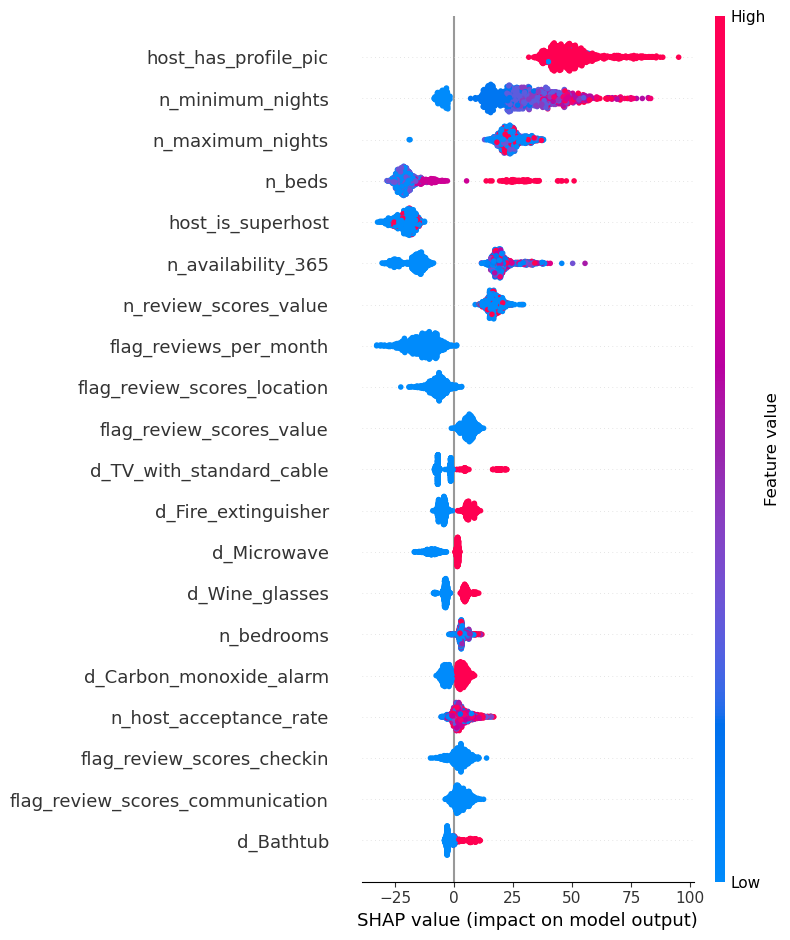

In [166]:
shap.summary_plot(shap_values, X_holdout, max_display=20, show= False)
plt.tight_layout()